In [1]:
%pylab inline
import numpy as np
import torch
import os

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from skimage.transform import resize
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_VAEGAN import *
from Model_alphaWGAN import Discriminator as alpha_D
from utils import *
from utils import sinkhorn_pointcloud as sp

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
gpu = True
workers = 4

reg = 5e-10

gamma = 20
beta = 10

Use_BRATS= True
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

gpu_0 = 2
gpu_1 = 2
torch_seed = 4
r_g = torch.manual_seed(torch_seed)

In [3]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
if Use_BRATS:
    #'flair' or 't2' or 't1ce'
    trainset = BRATSdataset(imgtype='flair')
    train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
                                               num_workers=workers)
if Use_ATLAS:
    trainset = ATLASdataset(augmentation=True)
    train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)

In [4]:
G = Generator(noise = latent_dim)
D = Discriminator()
E = Encoder(gpu_ind=gpu_0)
# E = alpha_D(out_class = latent_dim, is_dis=False)

G.cuda(gpu_0)
D.cuda(gpu_0)
E.cuda(gpu_0)

Encoder(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mean): Sequential(
    (0): Linear(in_features=32768, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=1000, bias=True)
  )
  (logvar): Sequential(
    (0): Linear(in_features=32768, out_features=2048, bias=True)
    (1): BatchNorm1d(2

In [5]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0001)
d_optimizer = optim.Adam(D.parameters(), lr=0.0001)
e_optimizer = optim.Adam(E.parameters(), lr=0.0001)

# Training

In [6]:
TOTAL_ITER = 100000

criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
d_iter = 1

checkpoint_pth = 'vae_checkpoint'
# load the highest savepoints of all models
df = load_loss(path=checkpoint_pth)
iteration = load_checkpoint(G, D, E, None, '_iter', path=checkpoint_pth)

real_y = torch.ones((BATCH_SIZE, 1)).cuda()
fake_y = torch.zeros((BATCH_SIZE, 1)).cuda()
gen_load = inf_train_gen(train_loader)

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.437   


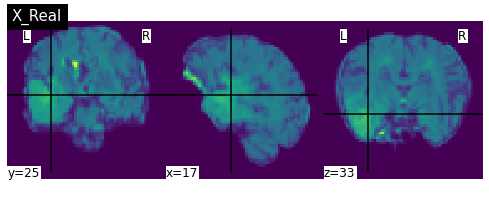

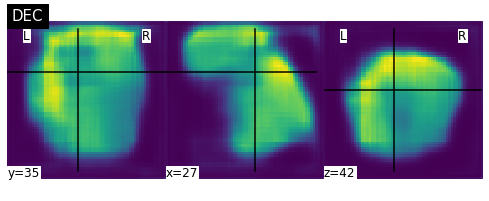

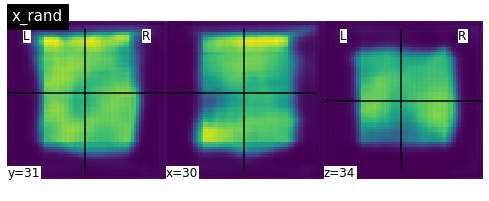

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 50000, sample_mean (blue): 0.0008269663667306304 sample_var:        0.9760529398918152, real_mean (yellow): 0.0006770205218344927 real_var: 1.001226782798767


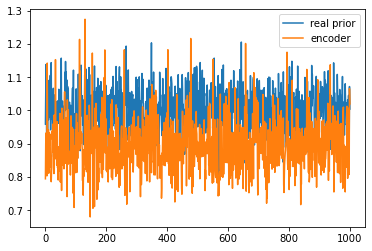

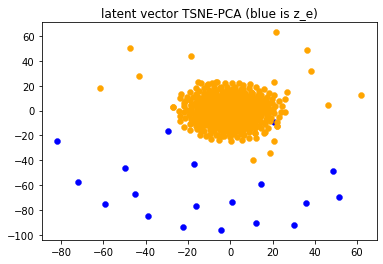

index: 50000, sample_mean (blue): -0.8272466659545898 sample_var:        0.058888569474220276, real_mean (yellow): -0.7808742523193359 real_var: 0.13318777084350586


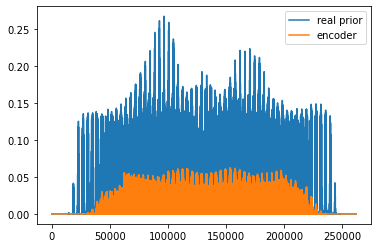

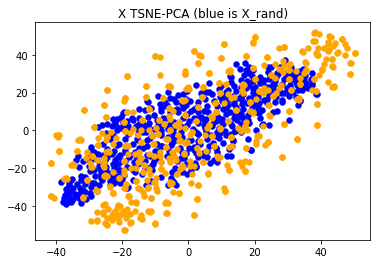


iteration: 50000, count: 0, Mean: 3.1855180263519287, cost 35.53569030761719 seconds
Total_mean:3.1855180263519287 STD:0.0
lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.348   


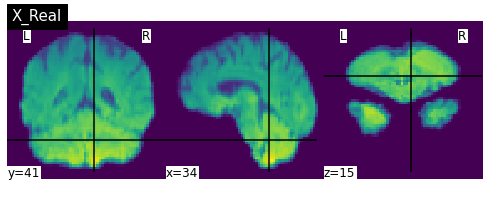

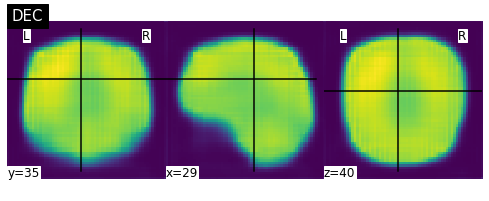

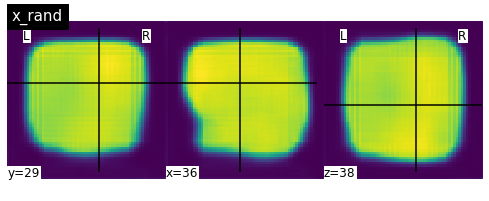

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.355   


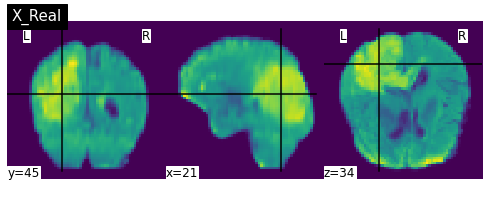

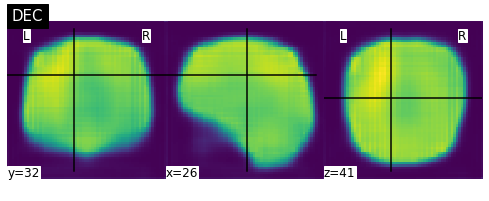

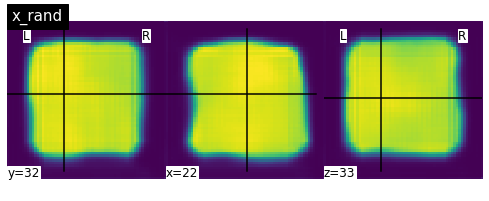

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 51000, sample_mean (blue): 0.005586930550634861 sample_var:        0.9492007493972778, real_mean (yellow): 0.00263888668268919 real_var: 1.0017634630203247


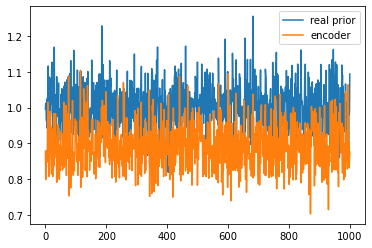

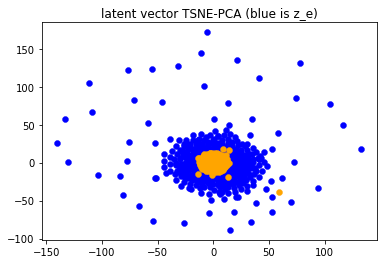

index: 51000, sample_mean (blue): -0.7285465002059937 sample_var:        0.11763181537389755, real_mean (yellow): -0.781836986541748 real_var: 0.1325308382511139


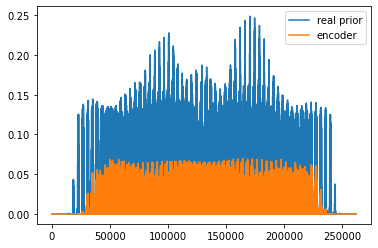

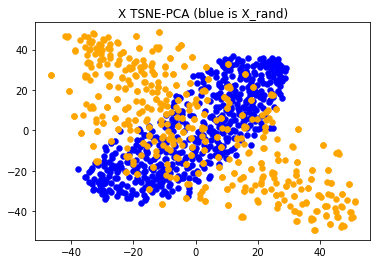

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.417   


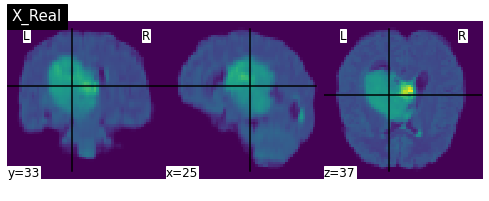

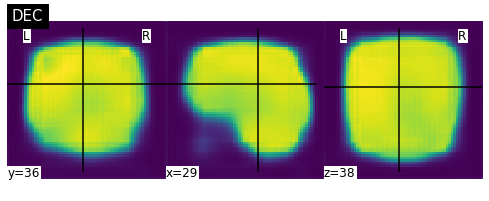

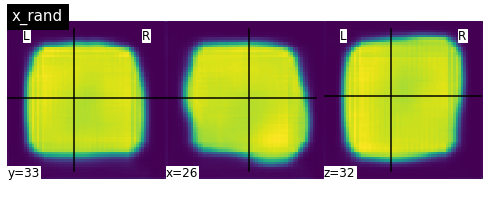

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.393   


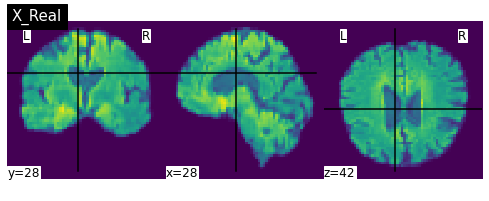

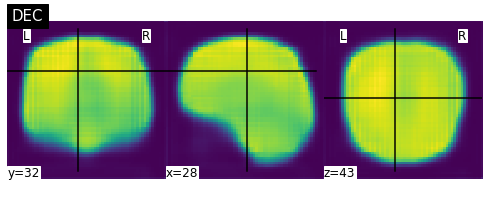

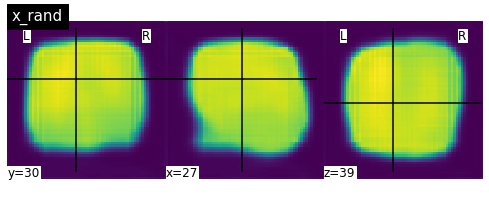

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 52000, sample_mean (blue): 0.005457965657114983 sample_var:        0.9621566534042358, real_mean (yellow): -0.0005776563193649054 real_var: 0.9973397254943848


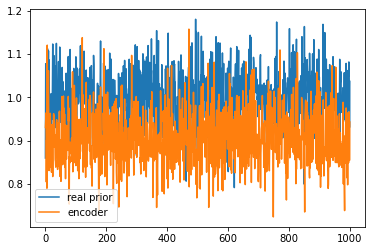

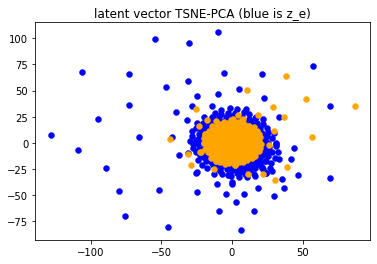

index: 52000, sample_mean (blue): -0.7289071083068848 sample_var:        0.11752146482467651, real_mean (yellow): -0.7819042801856995 real_var: 0.13208605349063873


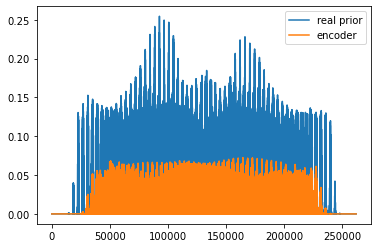

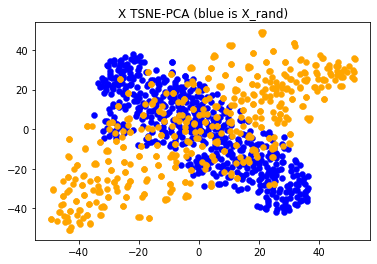

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.427   


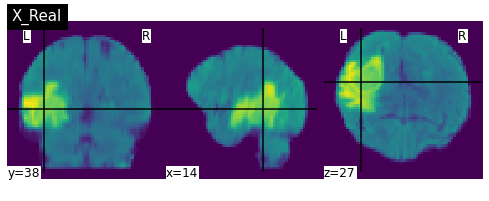

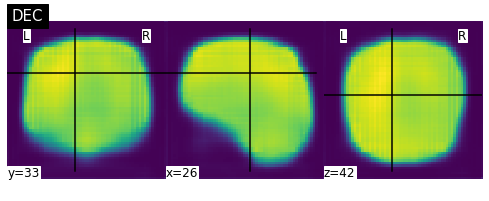

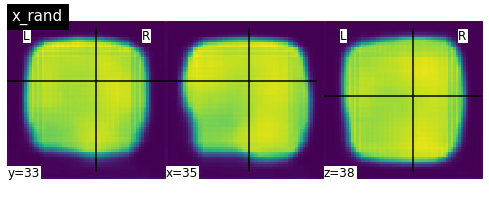

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.416   


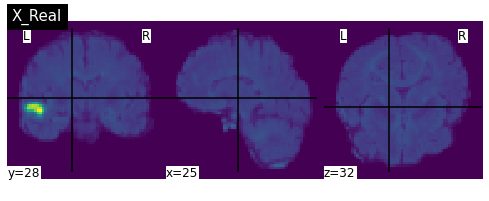

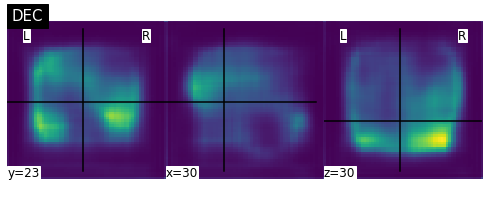

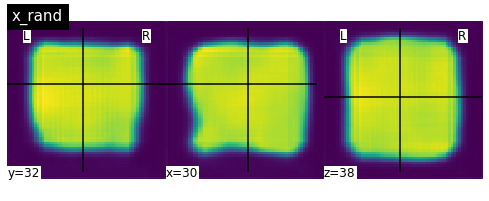

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 53000, sample_mean (blue): 0.004510203376412392 sample_var:        0.9745845794677734, real_mean (yellow): 0.0012875919928774238 real_var: 0.9984095692634583


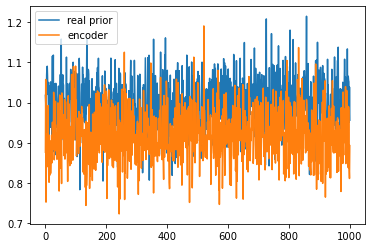

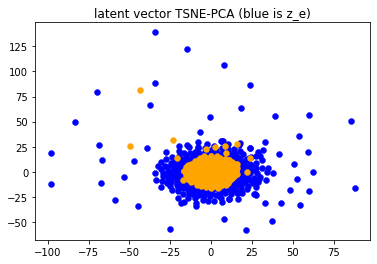

index: 53000, sample_mean (blue): -0.72874915599823 sample_var:        0.11762768030166626, real_mean (yellow): -0.7803621292114258 real_var: 0.13394656777381897


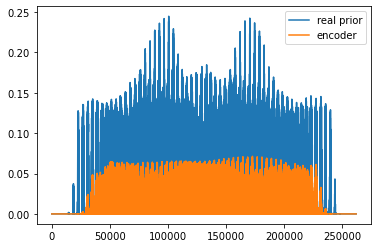

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.326   


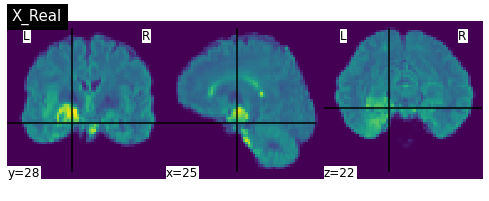

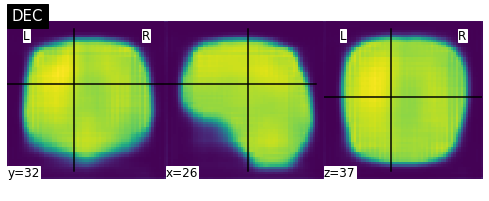

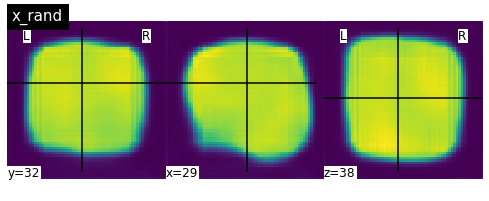

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.336   


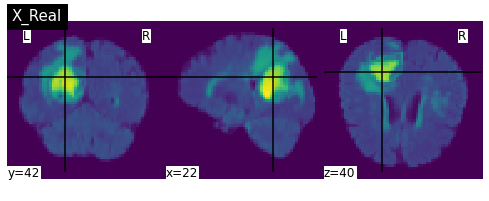

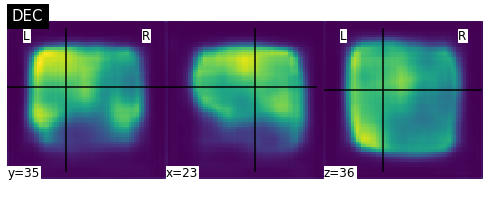

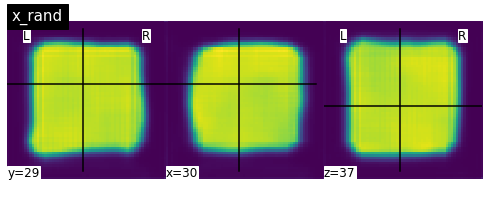

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 54000, sample_mean (blue): 0.005075094755738974 sample_var:        0.9771419763565063, real_mean (yellow): -0.0004881579661741853 real_var: 0.9995483756065369


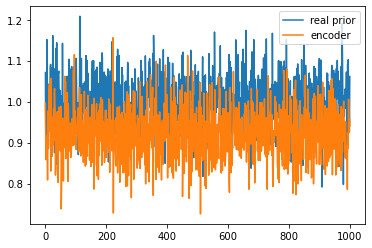

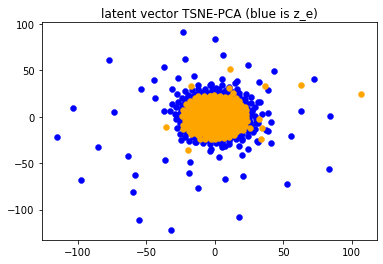

index: 54000, sample_mean (blue): -0.7285197973251343 sample_var:        0.11757974326610565, real_mean (yellow): -0.7808248996734619 real_var: 0.1330191045999527


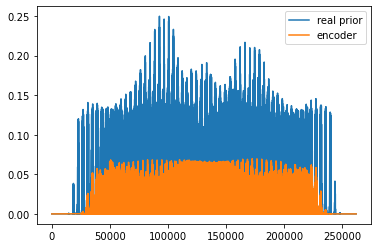

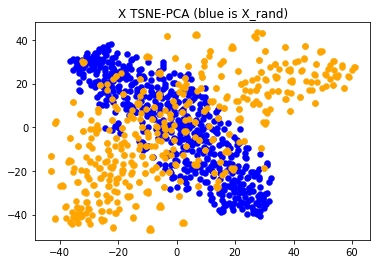

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.327   


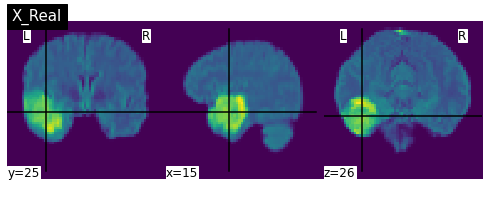

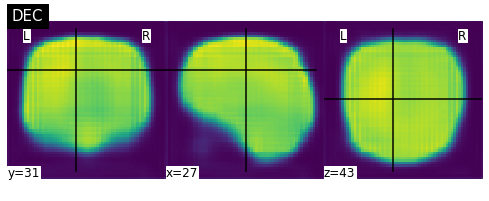

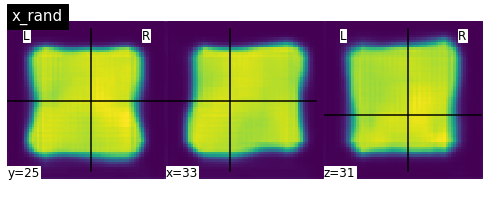

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.404   


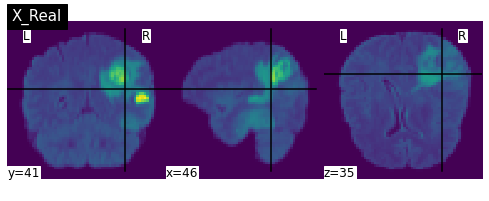

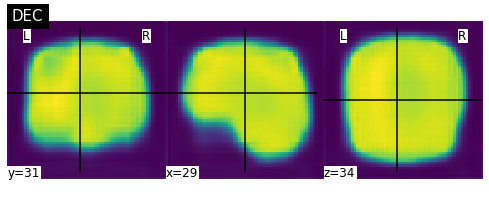

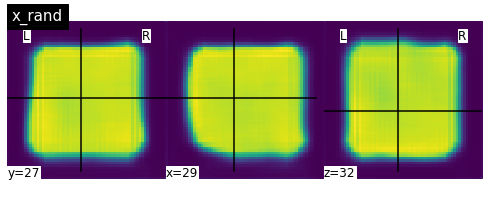

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 55000, sample_mean (blue): 0.006031430792063475 sample_var:        0.9776331782341003, real_mean (yellow): 0.000709719373844564 real_var: 1.0026237964630127


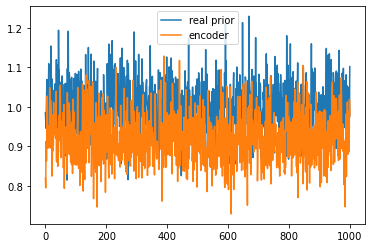

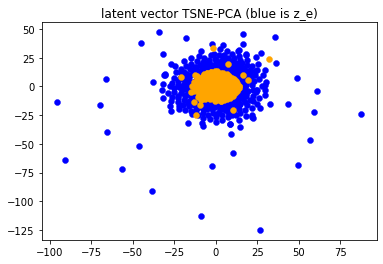

index: 55000, sample_mean (blue): -0.7289371490478516 sample_var:        0.1175408661365509, real_mean (yellow): -0.7798361778259277 real_var: 0.13456249237060547


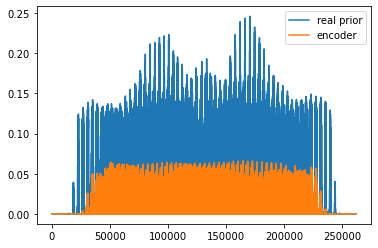

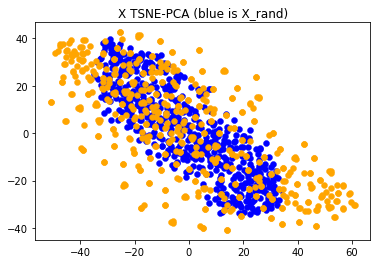


iteration: 55000, count: 0, Mean: 3.1977791786193848, cost 35.543293714523315 seconds
Total_mean:3.1977791786193848 STD:0.0
lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.331   


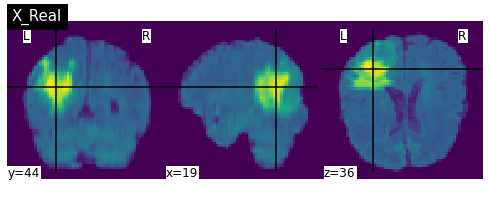

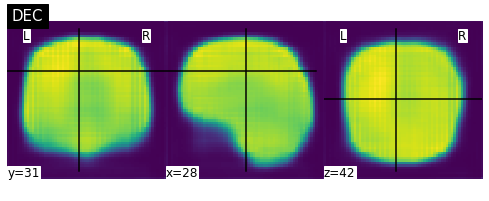

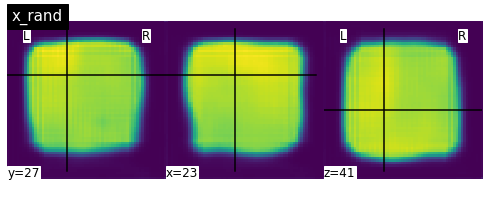

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.328   


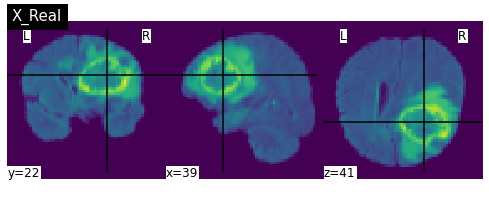

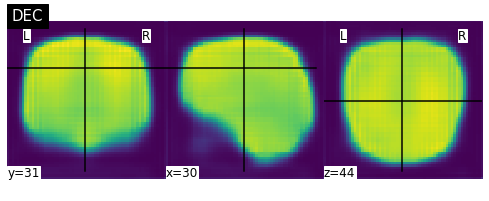

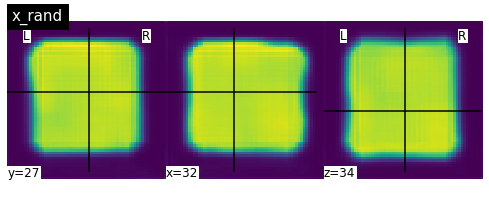

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 56000, sample_mean (blue): 0.004514400847256184 sample_var:        0.9798623323440552, real_mean (yellow): 0.0007101176306605339 real_var: 1.001883864402771


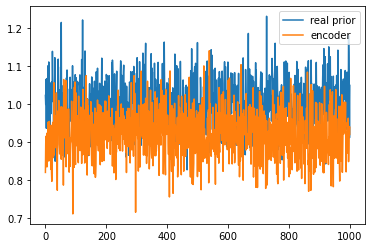

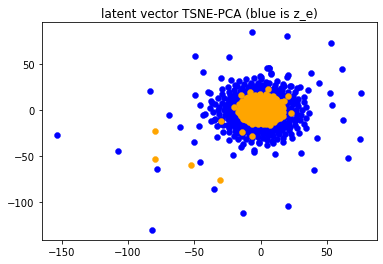

index: 56000, sample_mean (blue): -0.7285239100456238 sample_var:        0.11772219836711884, real_mean (yellow): -0.7814809679985046 real_var: 0.13273537158966064


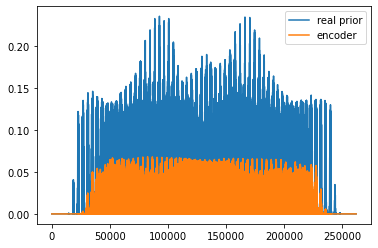

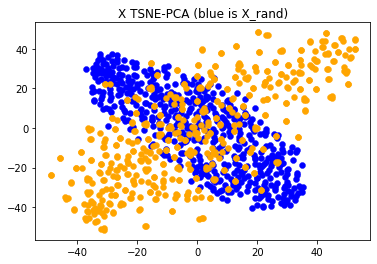

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.392   


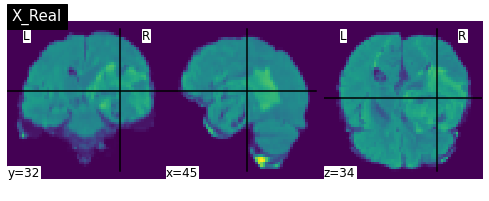

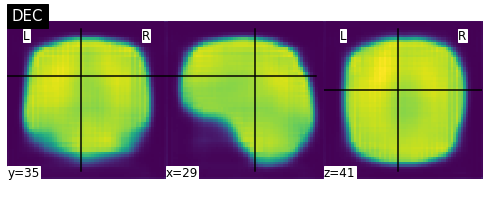

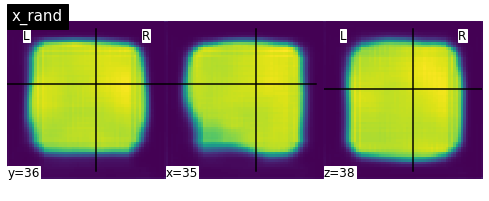

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.351   


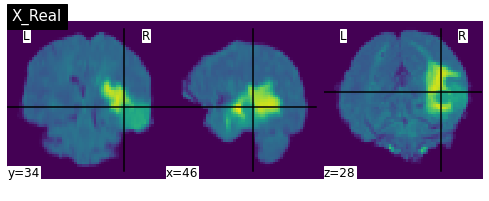

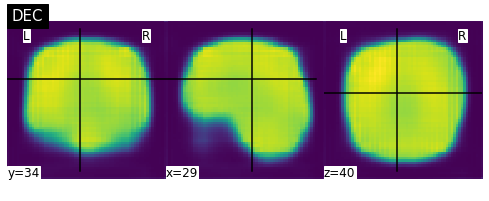

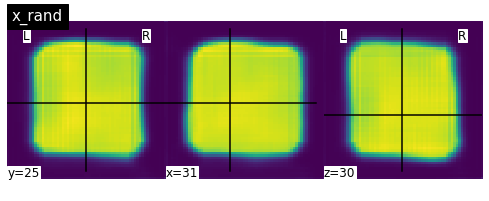

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 57000, sample_mean (blue): 0.0044822413474321365 sample_var:        0.9825567603111267, real_mean (yellow): 0.0010166751453652978 real_var: 0.997916579246521


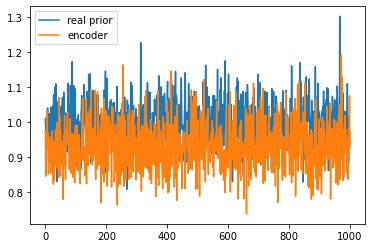

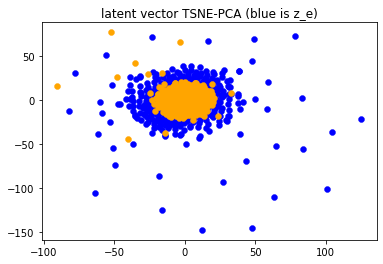

index: 57000, sample_mean (blue): -0.7286622524261475 sample_var:        0.11761526763439178, real_mean (yellow): -0.7807703018188477 real_var: 0.13366028666496277


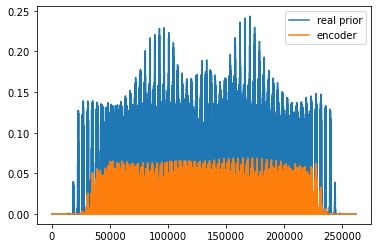

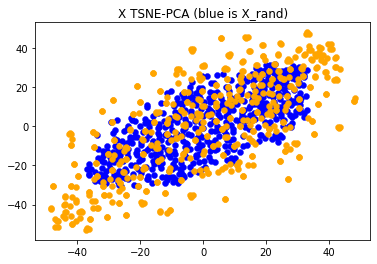

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.33    


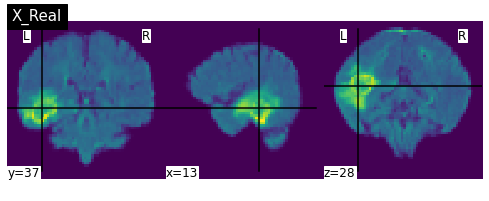

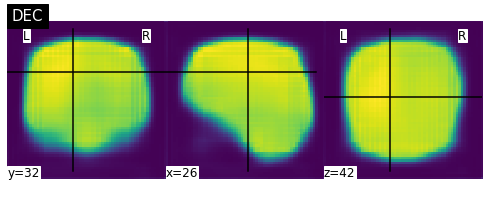

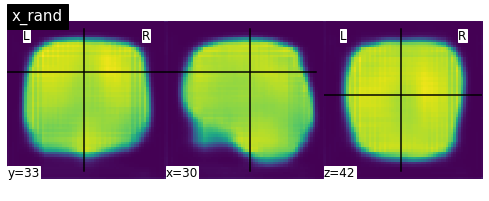

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.671   


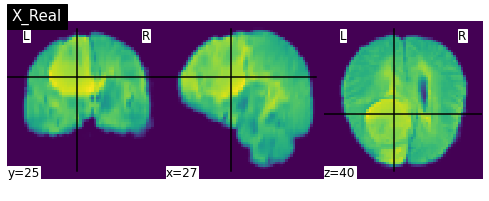

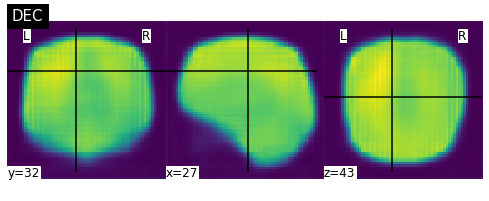

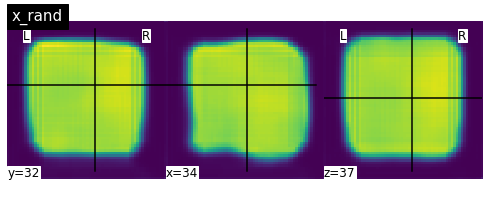

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 58000, sample_mean (blue): 0.0036681226920336485 sample_var:        0.9827970266342163, real_mean (yellow): -0.001717406208626926 real_var: 0.9981369972229004


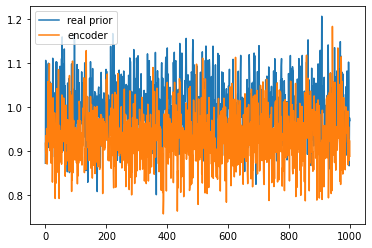

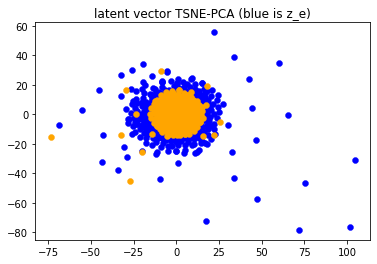

index: 58000, sample_mean (blue): -0.7286913394927979 sample_var:        0.1176026463508606, real_mean (yellow): -0.7829289436340332 real_var: 0.13101035356521606


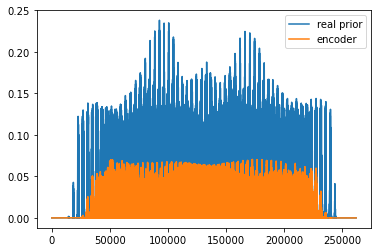

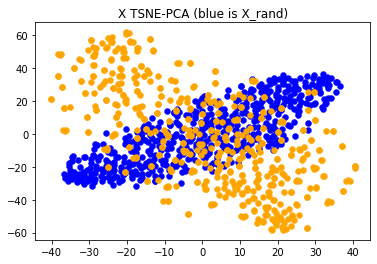

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.332   


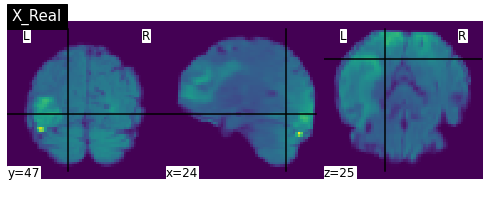

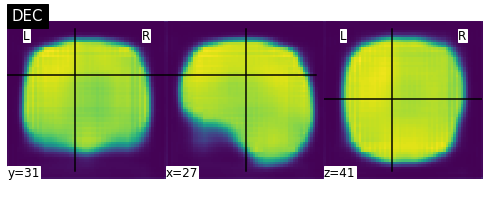

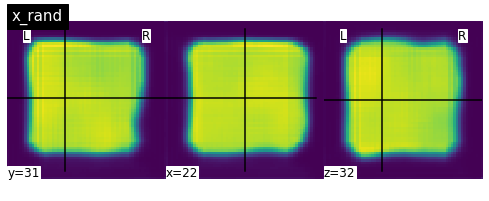

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.347   


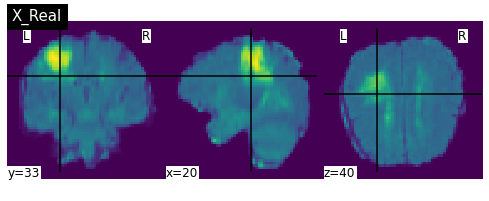

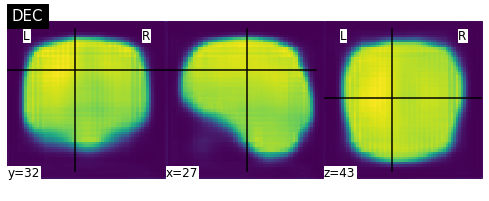

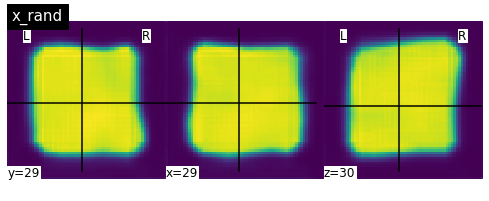

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 59000, sample_mean (blue): 0.004699951037764549 sample_var:        0.9888961911201477, real_mean (yellow): 0.004161082208156586 real_var: 1.0035557746887207


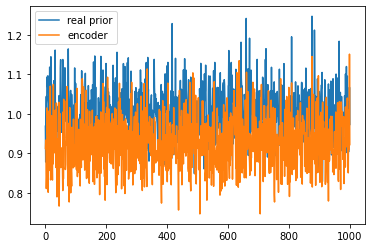

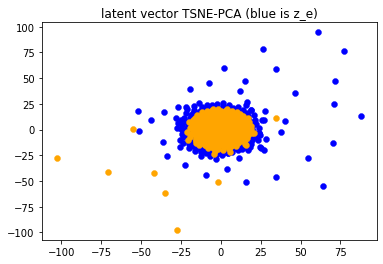

index: 59000, sample_mean (blue): -0.7285443544387817 sample_var:        0.11766676604747772, real_mean (yellow): -0.7801210284233093 real_var: 0.13434603810310364


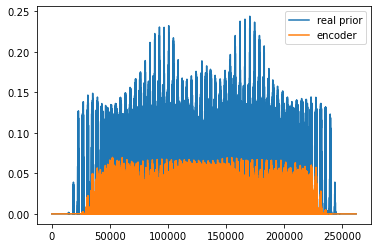

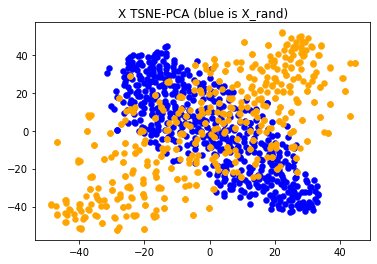

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.303   


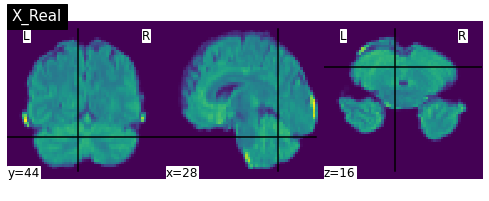

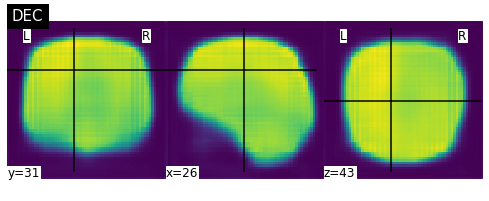

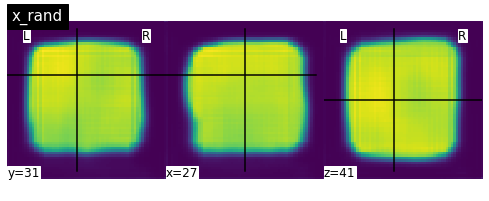

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.549   


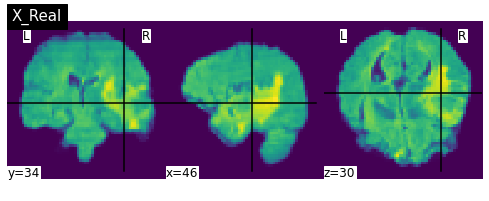

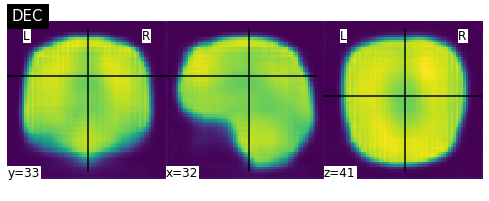

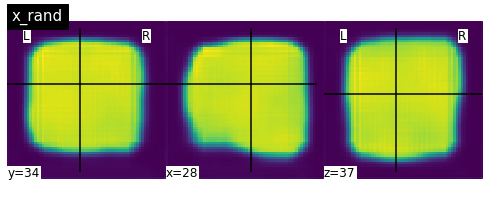

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 60000, sample_mean (blue): 0.0037919902242720127 sample_var:        0.9909528493881226, real_mean (yellow): -0.0005756472237408161 real_var: 1.0013599395751953


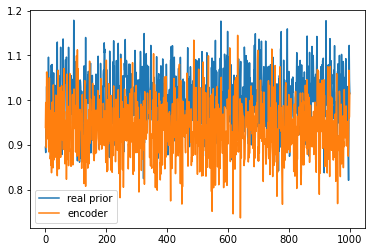

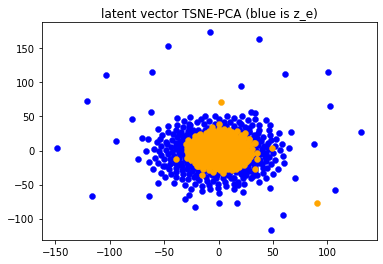

index: 60000, sample_mean (blue): -0.7284571528434753 sample_var:        0.11773856729269028, real_mean (yellow): -0.7808952331542969 real_var: 0.13335272669792175


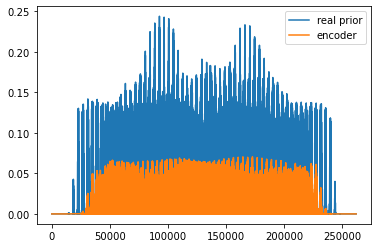

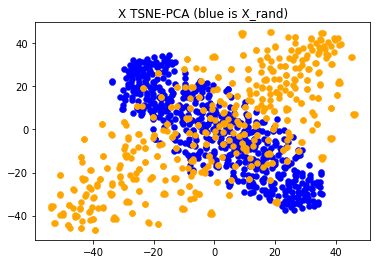


iteration: 60000, count: 0, Mean: 3.180502414703369, cost 35.20868945121765 seconds
Total_mean:3.180502414703369 STD:0.0
lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.293   


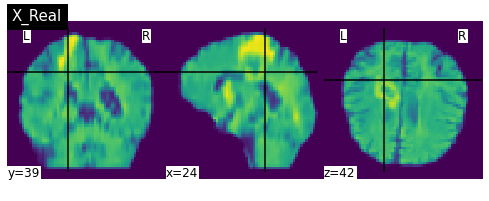

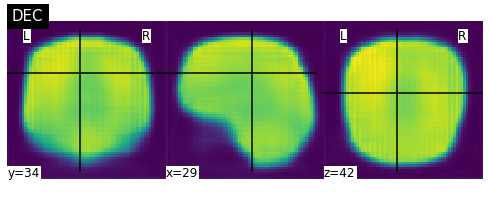

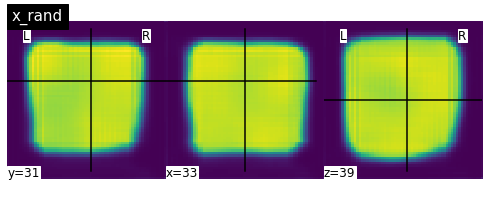

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.298   


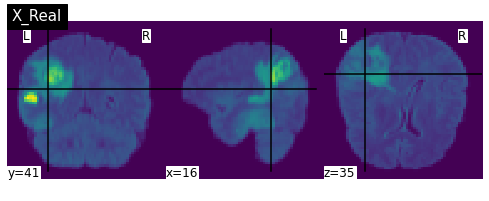

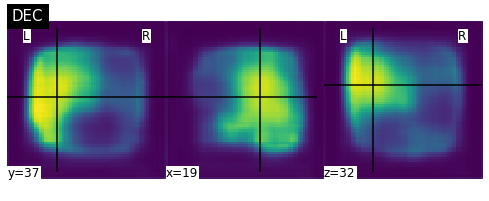

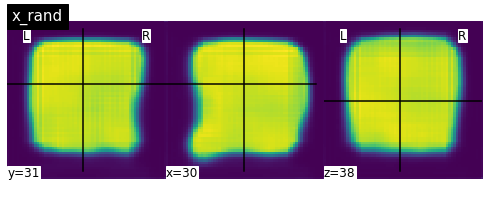

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 61000, sample_mean (blue): 0.003950275480747223 sample_var:        0.9948266744613647, real_mean (yellow): -0.0001256749383173883 real_var: 1.001237392425537


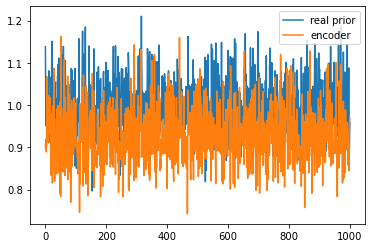

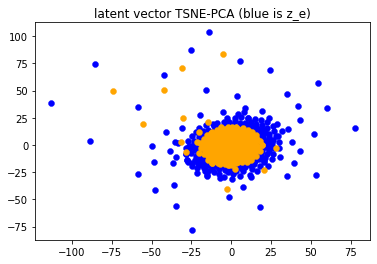

index: 61000, sample_mean (blue): -0.7283889651298523 sample_var:        0.11772097647190094, real_mean (yellow): -0.7811605930328369 real_var: 0.1332317590713501


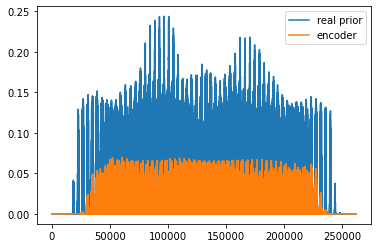

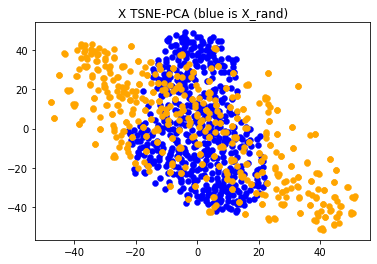

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.322   


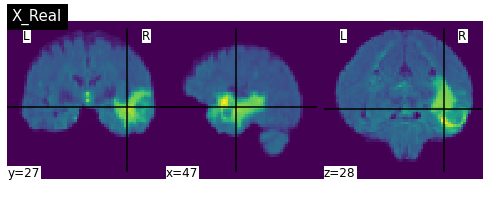

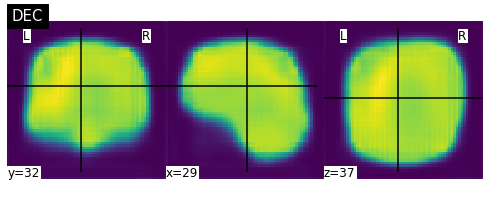

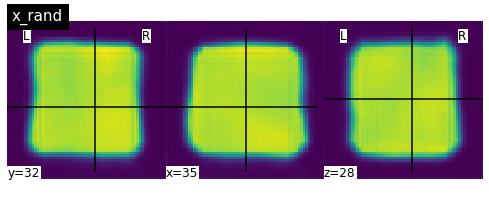

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.446   


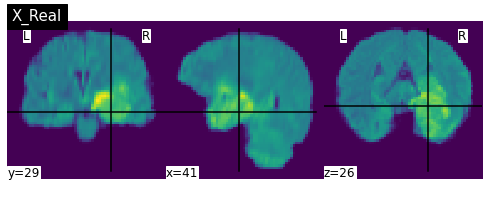

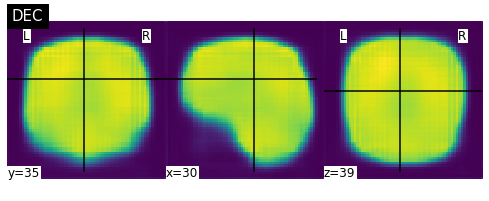

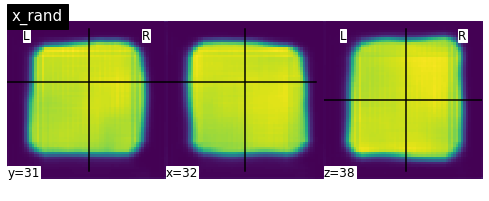

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 62000, sample_mean (blue): 0.0041860127821564674 sample_var:        0.9881318807601929, real_mean (yellow): 0.0005879936506971717 real_var: 0.9998992085456848


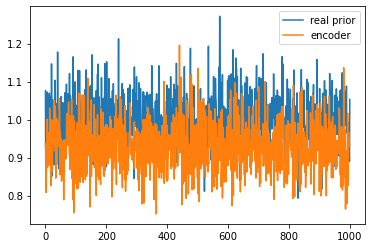

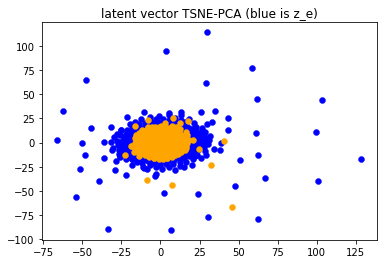

index: 62000, sample_mean (blue): -0.7286335229873657 sample_var:        0.1176699548959732, real_mean (yellow): -0.7793554663658142 real_var: 0.13538412749767303


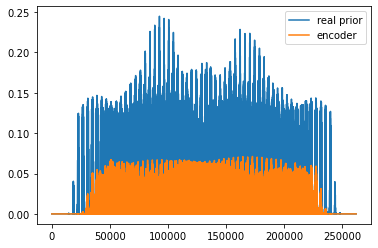

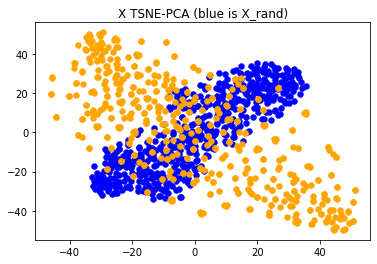

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.473   


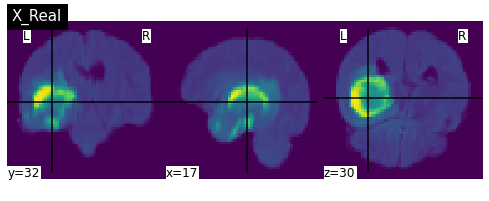

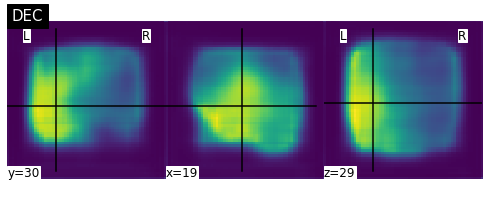

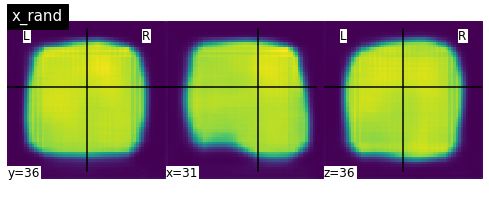

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.384   


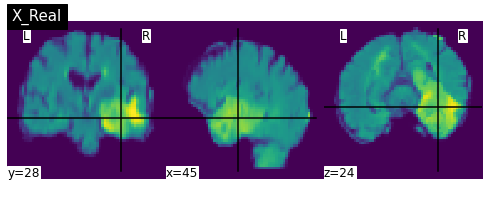

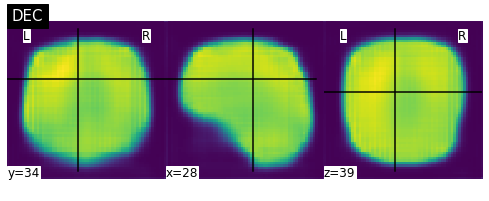

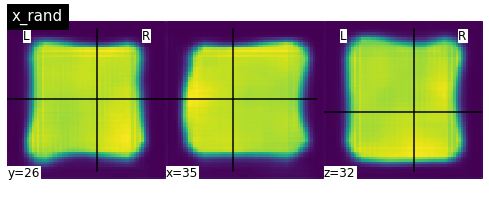

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 63000, sample_mean (blue): 0.005567383952438831 sample_var:        0.9802008867263794, real_mean (yellow): 0.001671609585173428 real_var: 0.9985131025314331


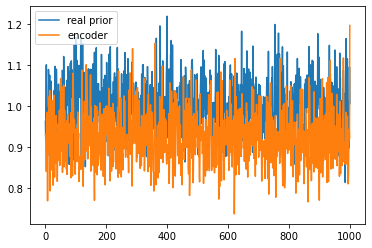

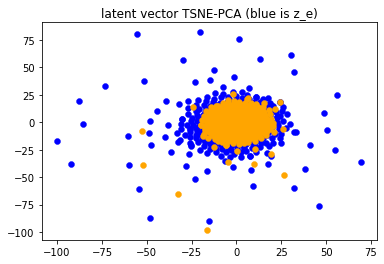

index: 63000, sample_mean (blue): -0.7287815809249878 sample_var:        0.11758293956518173, real_mean (yellow): -0.7819299697875977 real_var: 0.13224393129348755


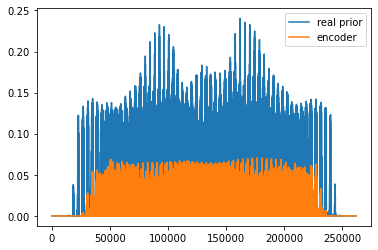

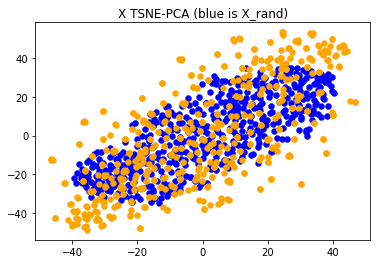

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.431   


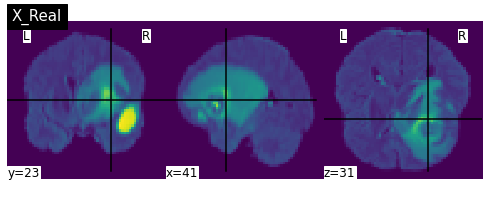

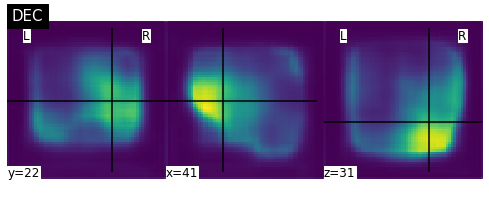

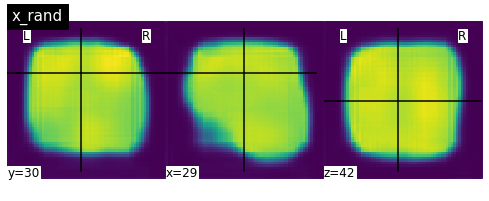

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.303   


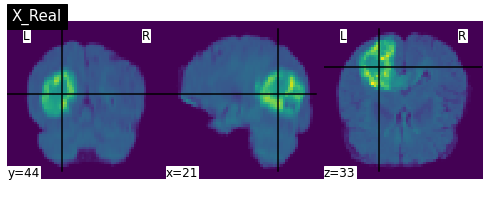

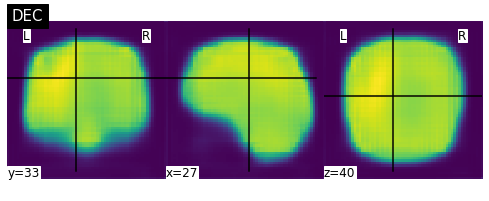

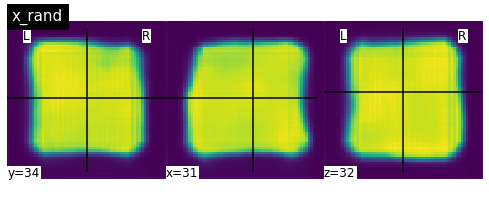

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 64000, sample_mean (blue): 0.004059706814587116 sample_var:        0.9887570142745972, real_mean (yellow): -0.001438636681996286 real_var: 1.0003015995025635


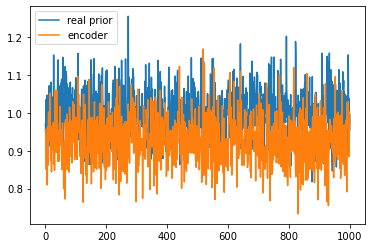

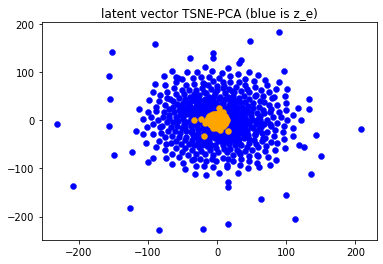

index: 64000, sample_mean (blue): -0.7286205291748047 sample_var:        0.11764878779649734, real_mean (yellow): -0.7807246446609497 real_var: 0.13355983793735504


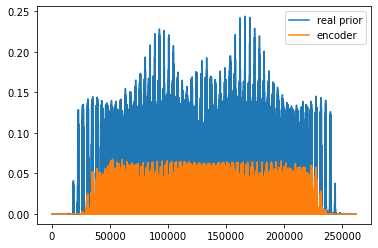

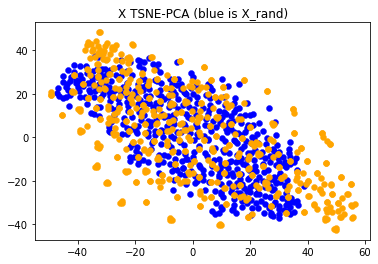

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.4     


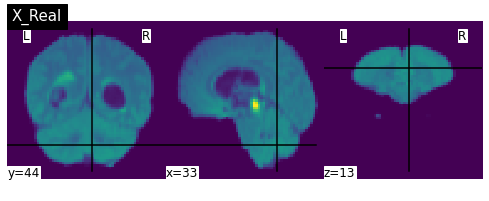

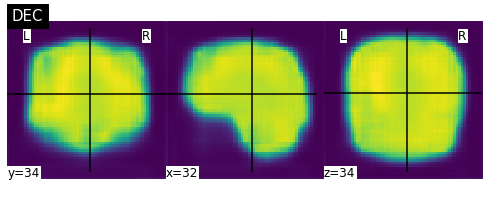

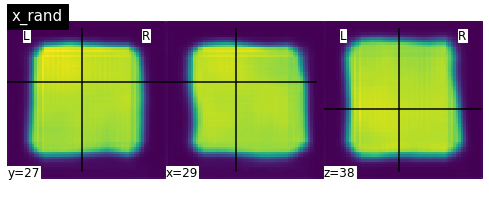

lossStr [50000/100000]
        D: -1.0    
        En_Ge: 0.347   


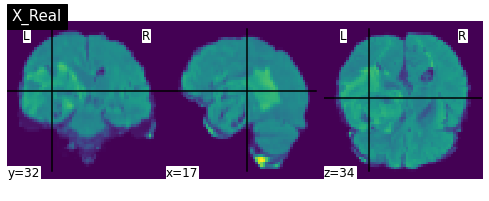

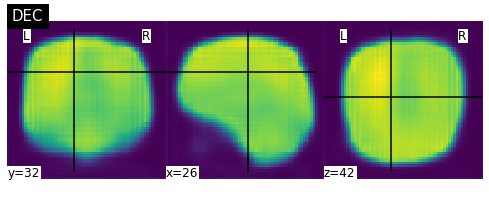

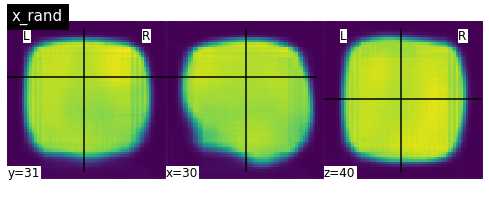

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

index: 65000, sample_mean (blue): 0.005669941194355488 sample_var:        0.9914439916610718, real_mean (yellow): -0.0004239949630573392 real_var: 1.000476598739624


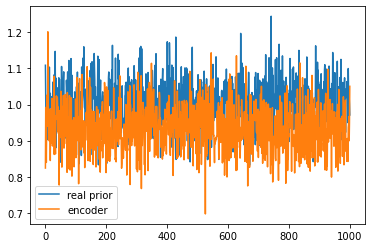

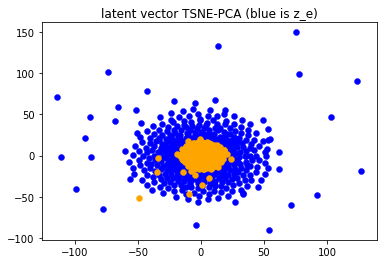

index: 65000, sample_mean (blue): -0.7290372848510742 sample_var:        0.11746230721473694, real_mean (yellow): -0.781969428062439 real_var: 0.13209259510040283


In [ ]:
for step in range(iteration, TOTAL_ITER):

    real_images = gen_load.__next__().cuda(gpu_0)
    _batch_size = real_images.size(0)
    z_rand = torch.randn((_batch_size, latent_dim), requires_grad=False).cuda(gpu_0)
    ###############################################
    # Train D 
    ###############################################
    for i in range(d_iter):
        d_optimizer.zero_grad()
        mean,logvar,code = E(real_images)
#             code = E(real_images).view(_batch_size,-1).cuda(gpu_0)
        d_real_loss = -D(real_images).mean()
        x_hat = G(code)
        x_rand = G(z_rand)
#             gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat, cuda_ind=gpu_0)
#             gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand, cuda_ind=gpu_0)
        d_recon_loss = D(x_hat).mean()
        d_fake_loss = D(x_rand).mean()

        dis_loss = d_recon_loss+d_real_loss + d_fake_loss# + gradient_penalty_r + gradient_penalty_h
        dis_loss.backward(retain_graph=True)
        d_optimizer.step()

    ###############################################
    # Train G
    ###############################################
    g_optimizer.zero_grad()

    gen_img_loss = -(d_real_loss + d_recon_loss+ d_fake_loss)
    rec_loss = ((G(code) - real_images)**2).mean()

    err_dec = gamma* rec_loss + gen_img_loss

    err_dec.backward(retain_graph=True)
    g_optimizer.step()
    ###############################################
    # Train E KL
    ###############################################
    mean,logvar,code = E(real_images)
    prior_loss = 1+logvar-mean.pow(2) - logvar.exp()
    prior_loss = (-0.5*torch.sum(prior_loss))/torch.numel(mean.data)
    err_enc = prior_loss + beta*rec_loss
    ## Train E WL ##############################
#         z_hat = E(real_images).view(_batch_size,-1).cuda(gpu_0)
#         code = z_hat
#         w_dist = sp.sinkhorn_loss(torch.transpose(z_rand, 0, 1), torch.transpose(z_hat, 0, 1), 0.1, 1000, 100, gpu=gpu_0)
#         err_enc = w_dist + beta*rec_loss
    ###############################################

    e_optimizer.zero_grad()
    err_enc.backward()
    e_optimizer.step()
    
    ###############################################
    # Model Save
    ###############################################
    if step % 500 == 0:
        lossStr = '[{}/{}]'.format(iteration,TOTAL_ITER) + '\n\
        D: {:<8.3}'.format(dis_loss.item()) + '\n\
        En_Ge: {:<8.3}'.format(err_enc.item())
        
        print('lossStr', lossStr)
        feat = np.squeeze((0.5*real_images[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        
        plotting.plot_img(feat,title="X_Real")
        plotting.show()

        feat = np.squeeze((0.5*x_hat[0]+0.5).detach().cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="DEC")
        
        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="x_rand")
        plotting.show()
        
    if step % 1000 == 0 and step:
        viz_pca_tsne([E], trainset, is_tsne=True, latent_size=latent_dim, index=step, is_cd=True, gpu_ind=gpu_1)
        viz_pca_tsne([G], trainset, is_tsne=True, latent_size=latent_dim, index=step, gpu_ind=gpu_1)
        
    if (step % 5000 == 0 or step == 1000) and step:
        torch.save(G.state_dict(),f'./{checkpoint_pth}/G_iter'+str(step)+'.pth')
        torch.save(D.state_dict(),f'./{checkpoint_pth}/D_iter'+str(step)+'.pth')
        torch.save(E.state_dict(),f'./{checkpoint_pth}/E_iter'+str(step)+'.pth')
        write_loss(df, path=checkpoint_pth)
        calc_mmd(train_loader, G, step, count=1, gpu_ind=gpu_0, mode='rbf', path=checkpoint_pth, no_write=False)
        
    loss_dict = {
        'd_real_loss': [d_real_loss.item()],
        'd_recon': [d_recon_loss.item()],
        'd_fake': [d_fake_loss.item()],
        'err_enc': [err_enc.item()],
    }
    df = add_loss(df, loss_dict)
        
    